### To observe videos with convergence open this notebook using [JupyterViewer](https://nbviewer.jupyter.org/)

In [8]:
from scipy import optimize, spatial
import numpy as np
import pandas as pd
from numpy import sin, cos, exp
import operator
from tqdm import tqdm_notebook as tqdm

import seaborn as sns
import bokeh
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import axes3d

from IPython.display import clear_output
from IPython.core.debugger import set_trace

import warnings
warnings.filterwarnings("ignore")

%matplotlib notebook
%matplotlib inline



__Function:__ $ f(x, y) = sin(x)e^{(1-cos(y))^2}+cos(y)e^{(1-sin(x))^2}+(x-y)^2 $  
__Domain:__ $ (x + 5)^2  + (y + 5)^2 < 25$

In [49]:
def domain(x):
    
    f = (x[0] + 5)**2 + (x[1] + 5)**2 - 25
    
    return f 

def f_mishras_bird(x):
    
    return sin(x[1])*exp( (1 - cos(x[0]))**2 ) + cos(x[0])*exp( (1 - sin(x[1]))**2 ) + (x[0] - x[1])**2

### Animaton helpers

In [3]:
def plot_simplex(x, ax, color = 'r'):
    
    p1 = ax.plot([x[0][0], x[1][0]],[x[0][1],x[1][1]],color)
    p2 = ax.plot([x[0][0], x[2][0]],[x[0][1],x[2][1]],color)
    p3 = ax.plot([x[1][0], x[2][0]],[x[1][1],x[2][1]],color)
    
    return p3

def update_NelderMead(frame):
    
    x = opt.simplexes[frame]
    p = plot_simplex(x, ax)
    
    return p
  
plt.rcParams["animation.html"] = "html5"
plt.rcParams['animation.ffmpeg_path'] =  'C:\\ffmpeg\\bin\\ffmpeg.exe'   

In [6]:
def get_canvas(func, x_bounds = [-10,0], y_bounds = [-10,0], n = 1000):

    x = np.linspace(*x_bounds, n)
    y = np.linspace(*y_bounds, n)
    
    xx, yy = np.meshgrid(x,y)
    
    grid = np.concatenate((np.expand_dims(xx, axis = 2),np.expand_dims(yy, axis = 2)), axis = 2)
    f_matrix = np.apply_along_axis(func, 2, grid)
    
    fig, ax = plt.subplots(figsize= (13,10))

    cm = ax.contourf(xx,yy,f_matrix, np.linspace(f_matrix.min(), f_matrix.max(), 20), cmap = 'viridis')
    plt.colorbar(cm, ax = ax)
    ax.add_artist(plt.Circle((-5, -5), 5, color='#000033', alpha=0.3))

    return fig, ax

Shade area is the $x$ domain

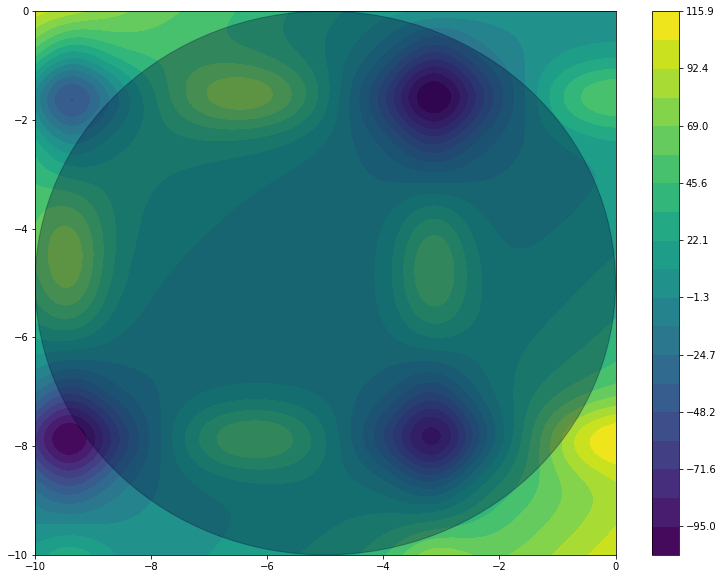

In [7]:
fig, ax = get_canvas(f_mishras_bird)

## Nelder-Mead

In [45]:
class NelderMeadOptimizer:
    
    '''
    Class for Nelder-Mead optimization process
    alpha - reflection coeff
    beta - shrinkage coeff
    gamma - extention coeff1
    '''
    
    def __init__(self, alpha = 1.0, beta = 0.5, gamma = 2.0):
        
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.oracle_calls = 0
        self.symplex_pairwise_sum = []
        self.f_ls = []
        self.simplexes = []
        self.iterations = 0
        
        
    def callback_default(self):
        
        pass
    
    def extract_simplex(self,f_x):
        
        # sorting by index
        f_x_sorted = sorted(f_x, key = lambda x: x[0])
        simplex = np.array([x for i,x,f in f_x_sorted])
        
        return simplex
     
    def check_domain(self, x):
        
        op_type = self.domain['type']
        func = self.domain['func']
        value = self.domain['value']
        ops = { "=": operator.eq,
               "<": operator.lt,
              '>' : operator.gt}
        
        return ops[op_type](func(x),value)
        
    def align(self, x, x_from_domain, max_iter = 1000):
        
        '''
        we'll simple move x to x_from_domain
        '''
        
        i = 0
        while not self.check_domain(x) or i >= max_iter:
            
            x = x + (x_from_domain - x)/2.
            i += 1
            
        return x    

    def get_pairw_dist(self, f_x):

        simplex = np.array([x for i,x,f in f_x])

        pairwise_sum = spatial.distance.pdist(simplex).sum()
        
        self.symplex_pairwise_sum.append(pairwise_sum)
        
        return pairwise_sum
    
    def get_init_simplex(self):
        
        scale_factor = 5./4

        coords = np.random.normal(loc = [-5,-5], scale = scale_factor, size = (self.n+1, self.n))

        return coords

    def minimize(self, func, domain = None, x0 = None, n = None, 
                 callback = callback_default, max_iter = 1000,
                 tol = 1e-7, freq = 100, verbose = True):
        
        
        '''
        domain = {'func': f, 'type': '='}
        '''
        
        self.n = n if n else len(x0)
        self.domain = domain
        
        if x0 is None:
            x0 = self.get_init_simplex()
        
        x = x0
            
        # init    
        f_x = [ [i, x_i, func(x_i)] for i,x_i in enumerate(x) ]    
        self.oracle_calls += len(x)

        while self.get_pairw_dist(f_x) > tol:
            
            self.simplexes += [self.extract_simplex(f_x)]
            
            if self.iterations >= max_iter:
                break
            self.iterations+=1    
                
            # sort by func value
            f_x = sorted(f_x, key = lambda x: x[2] ,reverse=True)

            x_h = f_x[0][1]
            x_g = f_x[1][1]
            x_l = f_x[-1][1]
            
            f_h = f_x[0][2]
            f_g = f_x[1][2]
            f_l = f_x[-1][2]
            self.f_ls.append(f_l)
            
            # mass center
            x_c = np.mean([ x for i,x,f in f_x[1:] ], axis = 0 )
            
            # reflection
            x_r = x_c + self.alpha*(x_c - x_h)
            
            if not self.check_domain(x_r):
                x_r = self.align(x_r, x_c)
                
            f_r = func(x_r)
            self.oracle_calls += 1
            
            # ideal
            if f_r <= f_l:
                # extention
                x_e = x_c + self.gamma*(x_r - x_c)
                if not self.check_domain(x_e):
                    x_e = self.align(x_e, x_l)
                f_e = func(x_e)
                self.oracle_calls += 1
                
                # change x_h
                f_x[0][1:] = [x_e, f_e] if f_e < f_r else [x_r, f_r]
                continue
                
            # not-ideal
            elif f_l <= f_r < f_g:
                # change x_h
                f_x[0][1:] = [x_r, f_r]
                continue
            
            # not-bad
            else:
                if f_g <= f_r < f_h:
                    # contraction from x_r to x_c
                    x_s = x_c + self.beta*(x_r - x_c)
                    f_s = func(x_s)
                    self.oracle_calls += 1
                    
                    if f_s <= f_r:
                        f_x[0][1:] = [x_s, f_s]
                        continue
                
                else:
                    # contraction from x_h to x_c
                    x_s = x_c + self.beta*(x_h - x_c)
                    f_s = func(x_s)
                    self.oracle_calls += 1
                
                    if f_s < f_h:
                        f_x[0][1:] = [x_s, f_s]
                        continue
   
                # shrinkage
                for i,x,f in f_x:
                    x_i = x_l + (x - x_l)/2.
                    f_x[i][1:] = [x_i, func(x_i)]
                    self.oracle_calls += 1
        
        simplex = self.extract_simplex(f_x)
        
        print ('Number of oracle calls: ', self.oracle_calls) 
        print ('Iterations: ', self.iterations) 
        print('Min F achieved:', f_l)
        print ('Converges to:', simplex)

        return simplex
    

### First starting point 

In [46]:
opt = NelderMeadOptimizer()

x0_1 = np.random.normal(loc = [-5,-2], scale = 0.3, size = (3,2))

x = opt.minimize(f_mishras_bird,
                 domain={'func':domain, 'type': '<', 'value':0},
                 tol = 1e-9,
                 x0 = x0_1)

Number of oracle calls:  149
Iterations:  71
Min F achieved: -106.76453674926474
Converges to: [[-3.13024681 -1.58214217]
 [-3.13024681 -1.58214217]
 [-3.13024681 -1.58214217]]


To observe the video with convergence open this notebook using [JupyterViewer](https://nbviewer.jupyter.org/)

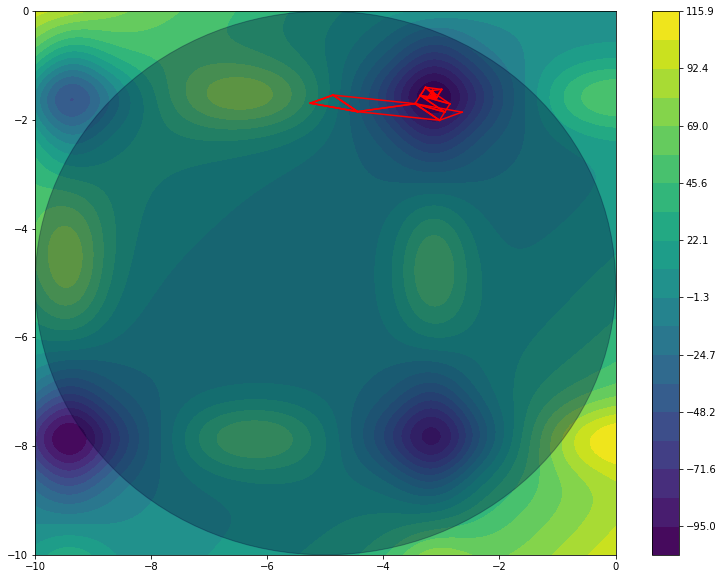

In [47]:
fig, ax = get_canvas(f_mishras_bird)
animation.FuncAnimation(fig, update_NelderMead, frames=range(opt.iterations), interval=200)

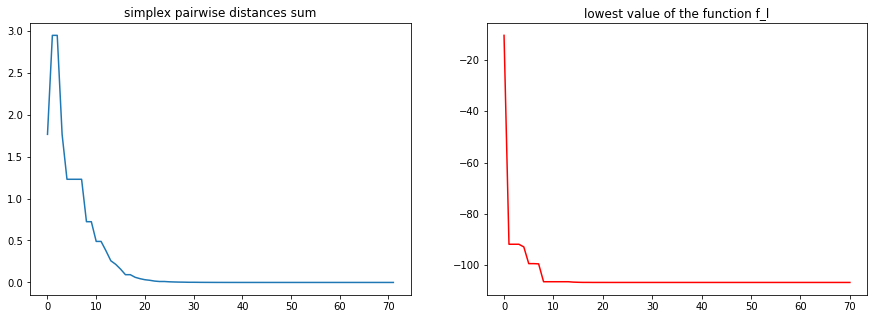

In [48]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5))

ax1.plot(opt.symplex_pairwise_sum)
ax1.set_title('simplex pairwise distances sum')
ax2.plot(opt.f_ls,'r')
ax2.set_title('lowest value of the function f_l')
plt.show()

### Second starting point 

In [41]:
x0_2 = np.random.normal(loc = [-6,-8], scale = 0.3, size = (3,2))

opt = NelderMeadOptimizer()

x = opt.minimize(f_mishras_bird,
                 domain={'func':domain, 'type': '<', 'value':0},
                 tol = 1e-9,
                 x0 = x0_2)

Number of oracle calls:  259
Iterations:  109
Min F achieved: -87.31088273300355
Converges to: [[-3.17572652 -7.81984778]
 [-3.17572652 -7.81984778]
 [-3.17572652 -7.81984778]]


To observe the video with convergence open this notebook using [JupyterViewer](https://nbviewer.jupyter.org/)

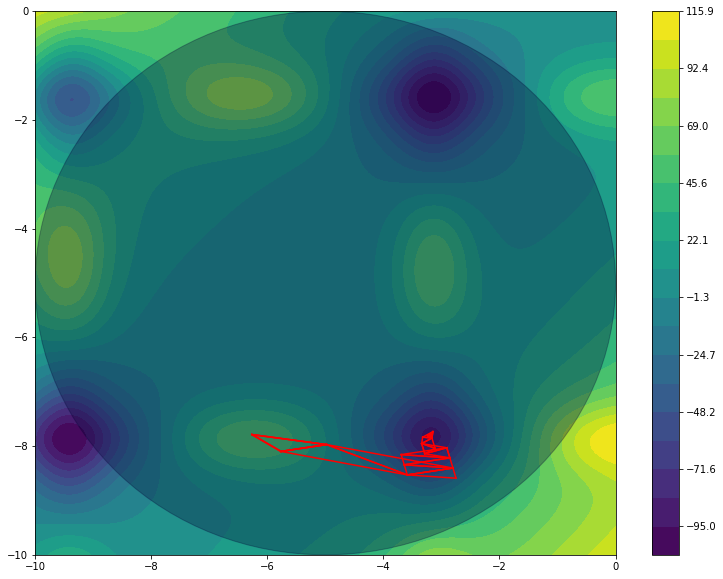

In [42]:
fig, ax = get_canvas(f_mishras_bird)
animation.FuncAnimation(fig, update_NelderMead, frames=range(opt.iterations), interval=200)

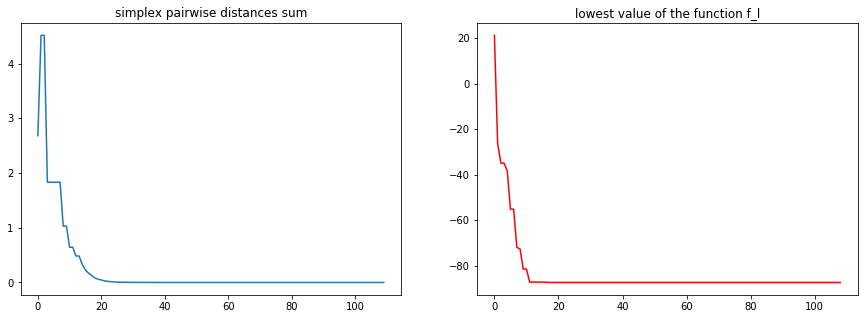

In [43]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5))

ax1.plot(opt.symplex_pairwise_sum)
ax1.set_title('simplex pairwise distances sum')
ax2.plot(opt.f_ls,'r')
ax2.set_title('lowest value of the function f_l')
plt.show()

### Show that with respect to different $\alpha$, $\beta$, $\gamma$ and one $x_0$ method may converge to the different points

In [8]:
x0 = np.random.normal(loc = [-3,-5], scale = 0.3, size = (3,2))

param_sets = [
    {'alpha':2.,
      'beta': 0.5,
      'gamma': 2},
    {'alpha':1.,
      'beta': 0.25,
      'gamma': 2},
    {'alpha':1.,
      'beta': 0.5,
      'gamma': 1}
]

results = {}

for i,params in enumerate(param_sets):

    print ('Optimizer {}'.format(i))

    opt = NelderMeadOptimizer(**params) # default params
    x = opt.minimize(f_mishras_bird,
                     domain={'func':domain, 'type': '<', 'value':0},
                     tol = 1e-9,
                     x0 = x0)
    results['opt{}'.format(i)] = [opt,x]

    print ('_________________________________')


Optimizer 0
Number of oracle calls:  2672
Iterations:  1001
Min F achieved -106.76453674926469
_________________________________
Optimizer 1
Number of oracle calls:  186
Iterations:  93
Min F achieved -87.31088273300355
_________________________________
Optimizer 2
Number of oracle calls:  814
Iterations:  384
Min F achieved -87.31088273300357
_________________________________



0it [00:00, ?it/s]
1it [00:09,  9.61s/it]
2it [00:12,  7.53s/it]
3it [00:22,  8.20s/it]


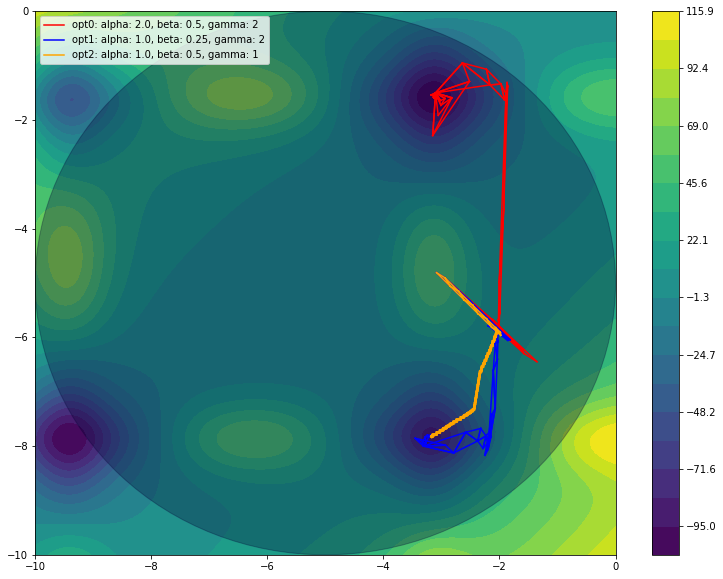

In [33]:
fig, ax = get_canvas(f_matrix)
colors = ['red', 'blue', 'orange']

for k,params,c in tqdm(zip(results.keys(), param_sets, colors)): 
    opt, x_opt = results[k]
    
    for frame in range(opt.iterations):
        x = opt.simplexes[frame]
        p = plot_simplex(x, ax, c)
        
    p[0].set_label(k + ': alpha: {0}, beta: {1}, gamma: {2}'.format(params['alpha'],
                                                                  params['beta'],
                                                                  params['gamma']))    

ax.legend()        
plt.show()

## Coordinate descent

In [77]:
class CoordDescentOptimizer:
    
    def __init__(self):
        
        self.f_vals = []
        self.x_s = []
        self.oracle_calls = 0
        self.iterations = 0
        
    def get_init_x0(self):
        
        scale_factor = 5./4

        return np.random.normal(loc = [-5,-5], scale = scale_factor, size = (self.n))
    
    def stopping_criteria(self):
        
        if len(self.f_vals) > 10:
            return np.var(self.f_vals[:-10]) > self.tol or np.var(self.x_s[:-10]) > self.tol
        
        else:
            return True
        
    def check_domain(self, x):
        
        op_type = self.domain['type']
        func = self.domain['func']
        value = self.domain['value']
        ops = { "=": operator.eq,
               "<": operator.lt,
              '>' : operator.gt}
        
        return ops[op_type](func(x),value)
    
    
    def align(self, x, x_from_domain):
        
        '''
        we'll simply contract x to x_from_domain 
        '''
        
        while not self.check_domain(x):
            x = x + (x_from_domain - x)*0.99
            
        return x        
        
    
    def minimize(self, func, domain = None, x0 = None,
                 n = 2, tol = 1e-10, max_iter = 1000,
                 gamma_0 = 1e-1, alpha_0 = 1e-1, verbose = True, freq = 1000):
        
        
        self.n = n if n else len(x0) 
        self.tol = tol
        self.gamma_0 = gamma_0
        self.alpha_0 = alpha_0
        self.domain = domain
        
        if x0 is None:
            x0 = self.get_init_x0()
            
        alpha_k = alpha_0
        x = x0
        
        while self.stopping_criteria():
            
            if self.iterations >= max_iter:
                break
            
            if self.iterations % freq == 0 and verbose:
                
                print ('It so far:', self.iterations )
            
            i = self.iterations%self.n    
            self.iterations += 1
            
            f_x = func(x)
            self.x_s.append(x)
            self.f_vals.append(f_x)
            
            e_i = np.zeros((self.n))
            e_i[i] = 1
            alpha_k = alpha_0
            s_k = (1./2*alpha_k)*(func( x + alpha_k*e_i ) - func( x - alpha_k*e_i ))*e_i
            gamma_k = gamma_0/(self.iterations + 1)
            x_prev = x
            x = x - gamma_k*s_k
            
            # if new x gone outside the area 
            if not self.check_domain(x):
                    x = self.align(x, x_prev)
            
            self.oracle_calls += 3
            
        print ('Number of oracle calls: ', self.oracle_calls) 
        print ('Iterations: ', self.iterations) 
        print('Min F achieved', f_x)
        print ('Converges to:', x)
            
        return x

In [78]:
opt = CoordDescentOptimizer()

x = opt.minimize(f_mishras_bird,
                 gamma_0 = 0.5,
                 alpha_0 = 0.7,
                 max_iter = int(1e3),
                 freq = int(1e3)/10,
                 domain={'func':domain, 'type': '<', 'value':0},
                 x0 = np.array([-3,-5]), # center of the simplex x0 of the Nelder-Mead method
                 n = 2, verbose = False)

Number of oracle calls:  3000
Iterations:  1000
Min F achieved -106.715419129051
Converges to: [-3.1169163  -1.59547268]


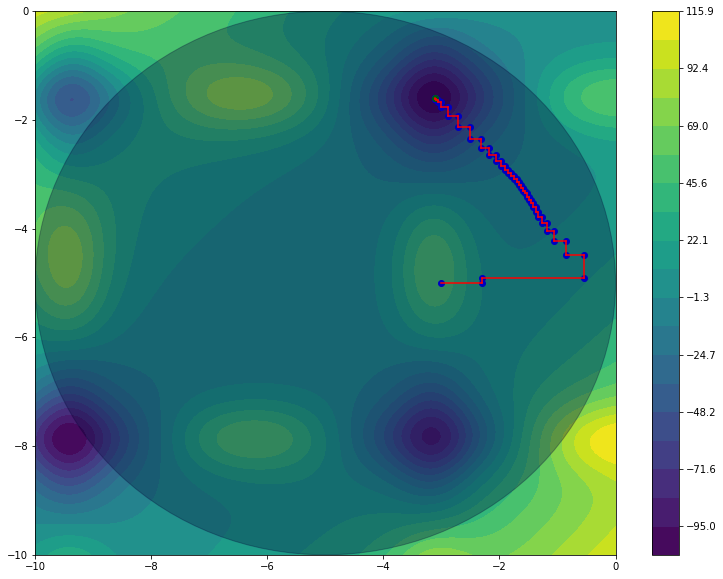

In [72]:
x_bounds = [-10,0]
y_bounds= [-10,0]
dx = dy = 1
n = 1000

x = np.linspace(*x_bounds, n)
y = np.linspace(*y_bounds, n)

fig_map, ax = plt.subplots(figsize= (13,10))

cm = ax.contourf(x,y,f_matrix, np.linspace(f_matrix.min(), f_matrix.max(), 20), cmap = 'viridis')
plt.colorbar(cm, ax = ax)
ax.add_artist(plt.Circle((-5, -5), 5, color='#000033', alpha=0.3))

for frame in tqdm(range(len(opt.x_s) - 2)):
    
    x = opt.x_s[frame:frame + 2]
    ax.plot([x[0][0], x[1][0]],[x[0][1],x[1][1]],'r')
    ax.scatter(opt.x_s[frame][0], opt.x_s[frame][1], c = 'g' if frame == len(opt.x_s) - 3 else 'b')

clear_output()    
plt.show()

## Conclusions

Coordinate Descent demands far more Oracle calls then Nelder-Mead method since at each iteration we need to evaluate function at least two times to compute the approximation of the derivative. 
In the Nelder-Mead method at each iteration the number of Oracle Calls may vary depending on initial simplex and parameters $\alpha$, $\beta$, $\gamma$